In [1]:
# 1 | Import Required Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

2025-06-20 11:04:42.707822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750417482.908935      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750417482.969210      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

# 2 | Load and Preprocess Data
IMAGE_SIZE = 224
BATCH_SIZE = 32

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

train_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/tomatoleaf/tomato/train',
    labels='inferred',
    label_mode='categorical',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/tomatoleaf/tomato/val',
    labels='inferred',
    label_mode='categorical',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Apply normalization and augmentation
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.map(lambda x, y: (data_augmentation(x / 255.0), y), num_parallel_calls=AUTOTUNE)
val_data = val_data.map(lambda x, y: (x / 255.0, y), num_parallel_calls=AUTOTUNE)

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)

I0000 00:00:1750417498.947332      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [3]:
# 3 | Build the VGG16-Based Model (Without Pretrained Weights)
base_model = VGG16(weights=None, include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = True  # Fine-tune whole model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(train_data.element_spec[1].shape[1], activation='softmax')  # num_classes
])

In [4]:
# 4 | Compile the Model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [5]:
# 5 | Define Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)
]


In [6]:
# 6 | Train Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]
)

Epoch 1/25


I0000 00:00:1750417513.558440      58 service.cc:148] XLA service 0x7df3b0002260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750417513.559108      58 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750417514.620432      58 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750417535.664812      58 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 128s 311ms/step - accuracy: 0.2818 - loss: 2.4166 - val_accuracy: 0.1000 - val_loss: 2.6805 - learning_rate: 1.0000e-04
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 235ms/step - accuracy: 0.5180 - loss: 1.7614 - val_accuracy: 0.3380 - val_loss: 2.1574 - learning_rate: 1.0000e-04
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 235ms/step - accuracy: 0.6065 - loss: 1.5034 - val_accuracy: 0.1400 - val_loss: 9.0629 - learning_rate: 1.0000e-04
Epoch 4/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 235ms/step - accuracy: 0.6686 - loss: 1.3037 - val_accuracy: 0.3500 - val_loss: 3.8088 - learning_rate: 1.0000e-04
Epoch 5/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 235ms/step - accuracy: 0.7275 - loss: 1.1300 - val_accuracy: 0.4770 - val_loss: 2.3993 - learning_rate: 1.0000e-04
Epoch 6/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 235ms/step - accuracy: 0.8068 - loss: 0.9188 - val_accuracy: 0.4420 - val_loss: 3.2127 - learning_rate: 5.0000e-05
Epoch 7/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 234ms/step -

In [7]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,646,752 (170.31 MB)

 Trainable params: 14,881,738 (56.77 MB)

 Non-trainable params: 1,536 (6.00 KB)

 Optimizer params: 29,763,478 (113.54 MB)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8474 - loss: 0.8796
Validation Loss: 0.8695143461227417
Validation Accuracy: 0.8460000157356262


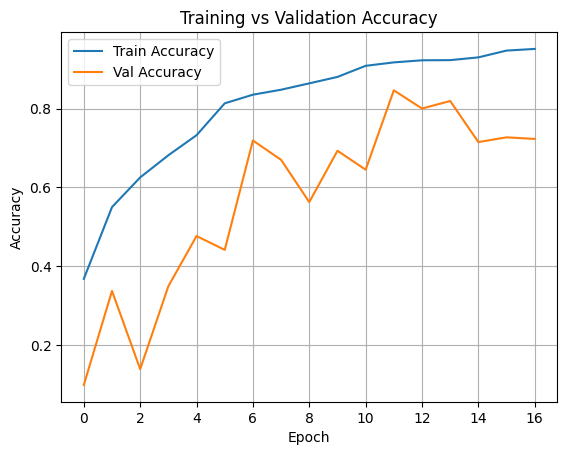

In [8]:
# 7 | Evaluate the Model
val_loss, val_accuracy = model.evaluate(val_data)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# 8 | Plot Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.grid(True)
plt.show()

In [9]:

# 8 | Evaluate
train_loss, train_acc = model.evaluate(train_data, verbose=0)
val_loss, val_acc = model.evaluate(val_data, verbose=0)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Training Accuracy: 0.9232
Validation Accuracy: 0.8460


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

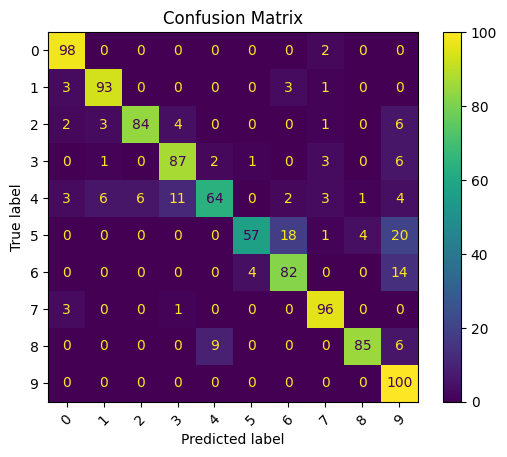

In [10]:
# 8 | Confusion Matrix
class_names = train_data.class_names if hasattr(train_data, 'class_names') else [str(i) for i in range(train_data.element_spec[1].shape[1])]

y_true = []
y_pred = []

for images, labels in val_data:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [11]:
# 9 | Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       100
           1       0.90      0.93      0.92       100
           2       0.93      0.84      0.88       100
           3       0.84      0.87      0.86       100
           4       0.85      0.64      0.73       100
           5       0.92      0.57      0.70       100
           6       0.78      0.82      0.80       100
           7       0.90      0.96      0.93       100
           8       0.94      0.85      0.89       100
           9       0.64      1.00      0.78       100

    accuracy                           0.85      1000
   macro avg       0.86      0.85      0.84      1000
weighted avg       0.86      0.85      0.84      1000

